In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))

X_train_all = load_all("X_train_all_90.pkl")
X_val_all = load_all("X_val_all_90.pkl")

In [5]:
print(len(X_train_all))

75000


In [6]:
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

y_train = load_y(path+"y_train.p")
y_val = load_y(path+"y_val.p")

In [7]:
from sklearn import svm

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1','l2'],
    #'dual' : [False, True],
#     'loss' : ['hinge','squared_hinge'],
     'C': [0.001, 0.01, 0.1, 1,10]
 }

In [14]:
gs_clf = GridSearchCV(svm.LinearSVC(verbose=4,max_iter=n_iter,dual=False), 
                      parameters, cv=5, iid=True, n_jobs=4,verbose=4)

In [15]:
stime = time.time()
model = gs_clf.fit(X_train_all, y_train)
print ("Training time:",time.time() - stime)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 25.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 150.5min finished


[LibLinear]Training time: 9079.122174263


In [16]:
model.best_score_

0.70372

In [17]:
from sklearn.calibration import CalibratedClassifierCV
ccmodel = CalibratedClassifierCV(model, cv='prefit')
ccmodel.fit(X_val_all, y_val)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=4),...     pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4),
            cv='prefit', method='sigmoid')

In [18]:
ccmodel.score(X_val_all, y_val)

0.6626

In [19]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.001, 'penalty': 'l1'}
C: 0.001
penalty: 'l1'


In [20]:
pickle.dump(model,open("SVM_All_SVCLinear_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [21]:
X_test_all = load_all("X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [22]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [23]:
from sklearn.metrics import accuracy_score
import sklearn

In [24]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []


# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel =svm.LinearSVC(verbose=4,
                             max_iter=n_iter,
                             dual=False,
                             C=model.best_params_['C'],
                             penalty=model.best_params_['penalty'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    ccBestModel = CalibratedClassifierCV(bestModel, cv=2)
    ccBestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    #print (X_train_cls.shape,y_train.shape,X_val_f.shape, y_val.shape)
    
    stime=time.time()
    preds_val = ccBestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)    
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test = ccBestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = ccBestModel.predict_proba(X_test_all)
    #print (bestModel.decision_function(X_test_f))
    #input("WWW")
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)
print (preds_test_probs)

SampleSize: 100
[LibLinear][LibLinear]Train Time:0.05 sec
Validation Accuracy: 50.00%
Validation Time:0.28 sec
Test Accuracy: 50.00%
Test Time:0.29 sec
(0.2857142857142808, 0.0, 0.0)
MRR: 0.2857142857142808
MRR Time:1.06 sec
SampleSize: 500
[LibLinear][LibLinear]Train Time:0.19 sec
Validation Accuracy: 51.80%
Validation Time:0.28 sec
Test Accuracy: 51.87%
Test Time:0.29 sec
(0.4462000000000015, 0.20266666666666666, 0.5653333333333334)
MRR: 0.4462000000000015
MRR Time:1.29 sec
SampleSize: 1000
[LibLinear][LibLinear]Train Time:0.50 sec
Validation Accuracy: 50.67%
Validation Time:0.34 sec
Test Accuracy: 50.41%
Test Time:0.35 sec
(0.4104878787878786, 0.17, 0.502)
MRR: 0.4104878787878786
MRR Time:1.02 sec
SampleSize: 10000
[LibLinear][LibLinear]Train Time:4.89 sec
Validation Accuracy: 62.91%
Validation Time:0.30 sec
Test Accuracy: 62.83%
Test Time:0.24 sec
(0.5755222222222247, 0.342, 0.748)
MRR: 0.5755222222222247
MRR Time:0.86 sec
SampleSize: 20000
[LibLinear][LibLinear]Train Time:10.16 se

In [25]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_LinearSVC_Accuracy.png")
    #plt.show()

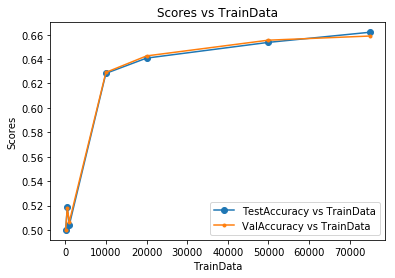

In [26]:
accuracyVisualization()

In [27]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_LinearSVC_Mrr.png")
    plt.show()

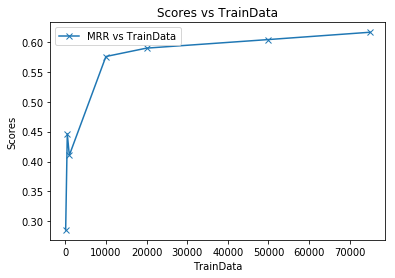

In [28]:
mrrVisualization()

In [29]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_All_LinearSVC_Precision.png")
    plt.show()

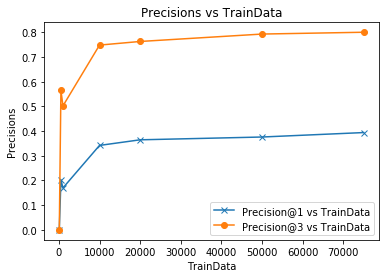

In [30]:
precisionVisualization()